In [ ]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import matplotlib.pyplot as plt


(array([3409.,  582.,  393.,  382.,  314.,  288.,  296.,  414.,  553.,
        3369.]),
 array([3.35356238e-23, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

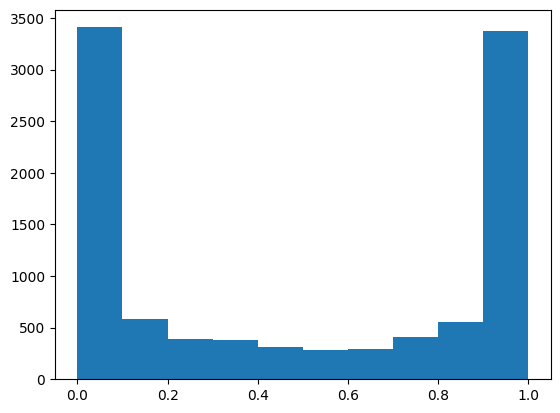

In [76]:
y = []
for i in range(10000):
    y.append(np.random.beta(0.2, 0.2))

plt.hist(y)